In [7]:
import numpy as np
import cv2
import random
import os
import glob
import itertools
import math
import re
from osgeo import gdal, gdal_array, ogr, osr
from matplotlib import pyplot as plt
from PIL import Image as pil_image
from keras.preprocessing.image import img_to_array
from sklearn.metrics import confusion_matrix
from pandas_ml import ConfusionMatrix
import itertools
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
## calculate sun-earth distance
##------------------------------
## this function accepts acquisition time and calculates sun-earth distance
## this is used in the correction of toa radiance for solar geometry
## input: AcqTime: earliestAcqTime str from WV2 .IMD file format: YYYY_MM_DDThh:mm:ss:ddddddZ;
## output: d_ES in astromnomical units
##--------------------------------------------------------------------------------------------

def calc_d_ES( AcqTime ):
    
    AcqTime = AcqTime.strip()
    print(AcqTime)
    year    = int(AcqTime[0:4])
    month_  = AcqTime[5:7]
    month   = int(month_.lstrip("0"))
    day_    = AcqTime[8:10]
    day     = int(day_.lstrip("0"))
    hh_     = AcqTime[11:13]
    hh      = float(hh_.lstrip("0"))
    mm_     = AcqTime[14:16]
    mm      = float(mm_.lstrip("0"))
    ss_     = AcqTime[17:19]
    ss      = float(ss_.lstrip("0"))
    ms    = float(AcqTime[20:-1])
    sec   = ss + ms/(1e6)
    
    UT   = hh + mm/60. + sec/3600.
    #print("UT: ",UT)
    
    if (month == 1 or month == 2):
        year = year - 1
        month= month + 12
        
    # calculate Juliad Day (Meeus, p.61, 1998)
    A = int(year/100)
    B = 2 - A + int(A/4)
    JD= int(365.25*(year+4716)) + int(30.6001*(month + 1)) + day + UT/24. + B - 1524.5
    #print("Julian Day: ", JD)
    # calculate Earth-Sun distance (U.S. Naval Observatory)
    D  = JD - 2451545.0
    g  = 357.529 + 0.98560028*D
    gi = math.cos(math.radians(g))
    gi2= math.cos(math.radians(2*g))
    
    d_ES = 1.00014 - 0.01671*gi - 0.00014*gi2
    #print(d_ES)
    
    return (d_ES)**2

In [3]:
def array2raster(newRasterfn, dataset, array, dtype="Float32"):
    """
    save GTiff file from numpy.array
    input:
        newRasterfn: new geotiff file name to save
        dataset : original tif file
        array : numpy.array to convert back to tif
        dtype: Byte or Float32.
    """
    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform() 

    driver = gdal.GetDriverByName('GTiff')

    # set data type to save.
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte": 
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")

    # set number of band.
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(array)
        else:
            outband.WriteArray(array[:,:,b])

    # setteing srs from input tif file.
    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

Cicia
['D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01']
['D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\\052985603010_01_P001_MUL', 'D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\\052985603010_01_P002_MUL', 'D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\\052985603010_01_P003_MUL']
imd_f: D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS-052985603010_01_P001.IMD
2010-08-17T22:21:53.527906Z
['D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\\052985603010_01_P001_MUL\\10AUG17222153-M2AS_R1C1-052985603010_01_P001.TIF', 'D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\\052985603010_01_P001_MUL\\10AUG17222153-M2AS_R1C2-052985603010_01_P001.TIF', 'D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\\052985603010_01_P001_MUL\\10AUG17222153-M2AS_R1C3-052985603010_01_P001.TIF', 'D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\\052985603010_01_P001_MUL\\1

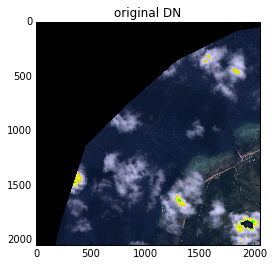

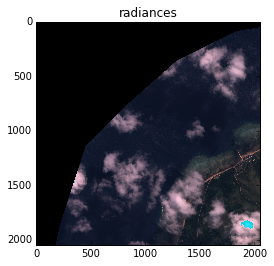

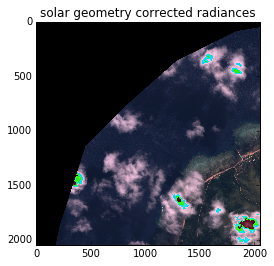

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R1C1-052985603010_01_P001_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R1C1-052985603010_01_P001_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R1C2-052985603010_01_P001.TIF  to correct
tif shape:  (2048, 2048, 8)


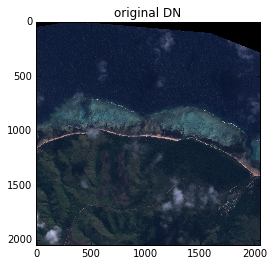

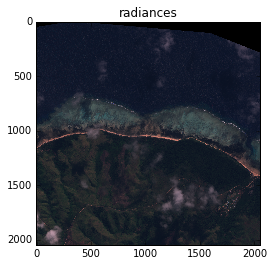

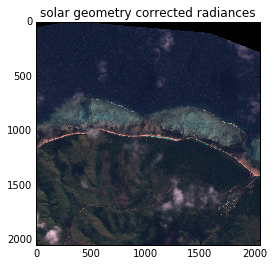

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R1C2-052985603010_01_P001_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R1C2-052985603010_01_P001_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R1C3-052985603010_01_P001.TIF  to correct
tif shape:  (2048, 1508, 8)


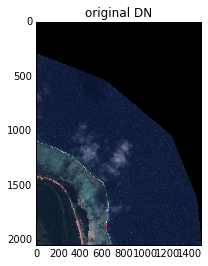

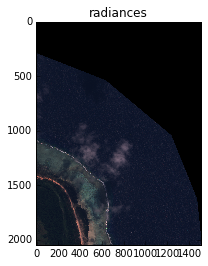

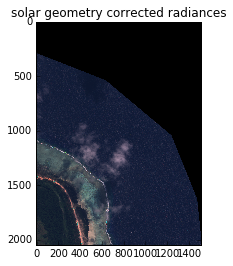

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R1C3-052985603010_01_P001_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R1C3-052985603010_01_P001_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R2C1-052985603010_01_P001.TIF  to correct
tif shape:  (2048, 2048, 8)


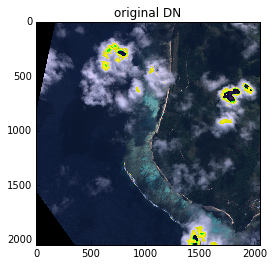

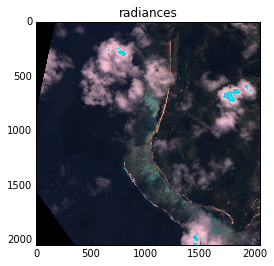

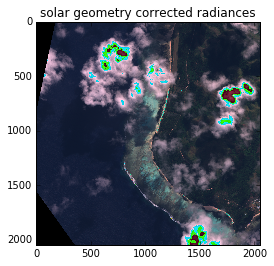

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R2C1-052985603010_01_P001_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R2C1-052985603010_01_P001_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R2C2-052985603010_01_P001.TIF  to correct
tif shape:  (2048, 2048, 8)


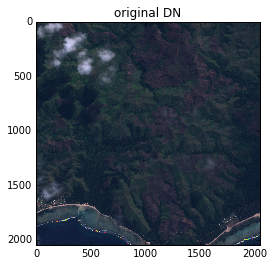

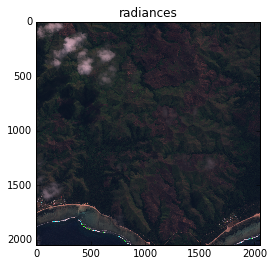

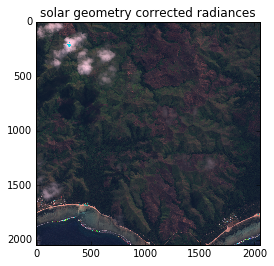

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R2C2-052985603010_01_P001_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R2C2-052985603010_01_P001_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R2C3-052985603010_01_P001.TIF  to correct
tif shape:  (2048, 1537, 8)


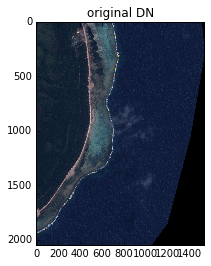

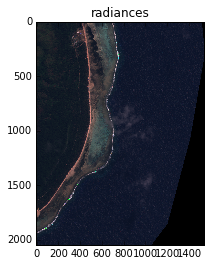

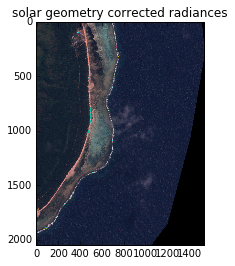

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R2C3-052985603010_01_P001_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R2C3-052985603010_01_P001_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R3C1-052985603010_01_P001.TIF  to correct
tif shape:  (838, 2048, 8)


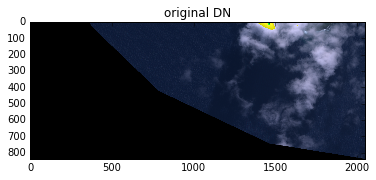

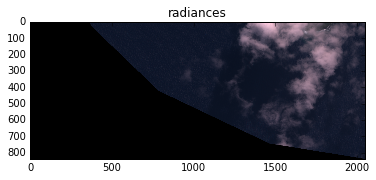

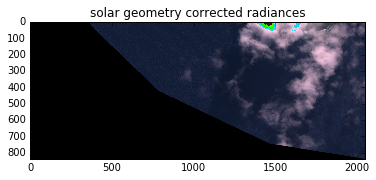

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R3C1-052985603010_01_P001_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R3C1-052985603010_01_P001_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R3C2-052985603010_01_P001.TIF  to correct
tif shape:  (916, 2048, 8)


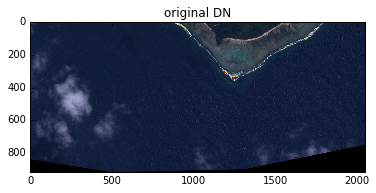

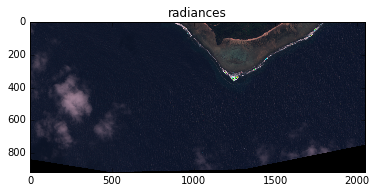

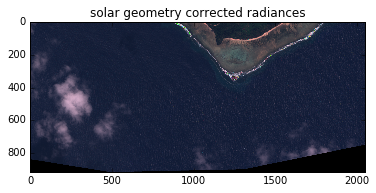

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R3C2-052985603010_01_P001_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R3C2-052985603010_01_P001_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R3C3-052985603010_01_P001.TIF  to correct
tif shape:  (749, 1050, 8)


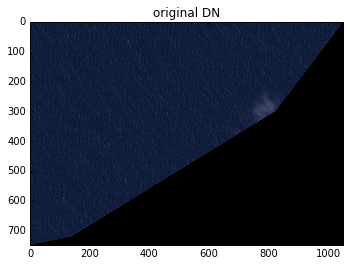

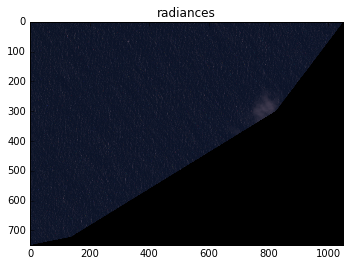

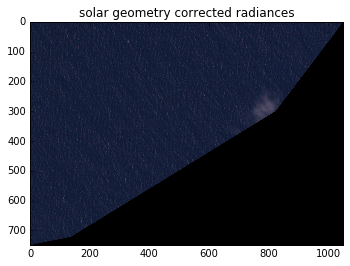

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R3C3-052985603010_01_P001_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P001_MUL\10AUG17222153-M2AS_R3C3-052985603010_01_P001_rad_solar_corrected.TIF
imd_f: D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS-052985603010_01_P002.IMD
2012-12-12T22:37:46.785902Z
['D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\\052985603010_01_P002_MUL\\12DEC12223746-M2AS_R1C1-052985603010_01_P002.TIF', 'D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\\052985603010_01_P002_MUL\\12DEC12223746-M2AS_R1C2-052985603010_01_P002.TIF', 'D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\\052985603010_01_P002_MUL\\12DEC12223746-M2AS_R1C3-052985603010_01_P002.TIF', 'D://NeMO-Net Data//Fiji Raw Imagery//Cicia/0529856030

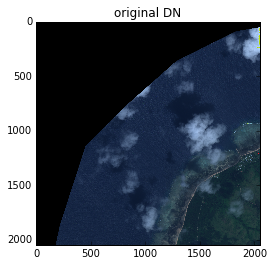

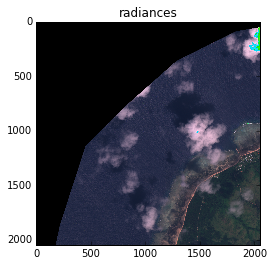

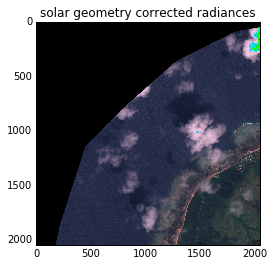

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R1C1-052985603010_01_P002_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R1C1-052985603010_01_P002_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R1C2-052985603010_01_P002.TIF  to correct
tif shape:  (2048, 2048, 8)


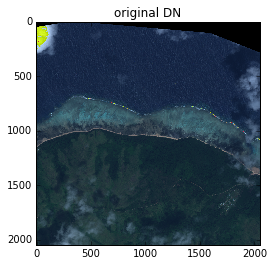

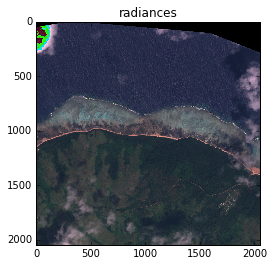

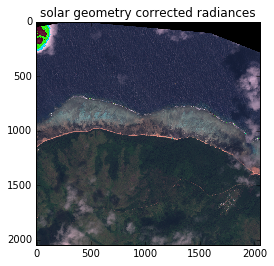

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R1C2-052985603010_01_P002_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R1C2-052985603010_01_P002_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R1C3-052985603010_01_P002.TIF  to correct
tif shape:  (2048, 1508, 8)


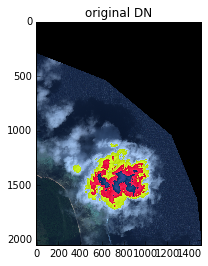

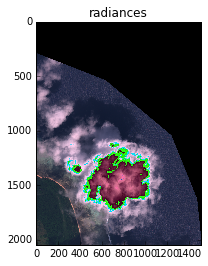

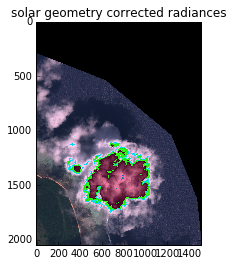

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R1C3-052985603010_01_P002_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R1C3-052985603010_01_P002_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R2C1-052985603010_01_P002.TIF  to correct
tif shape:  (2048, 2048, 8)


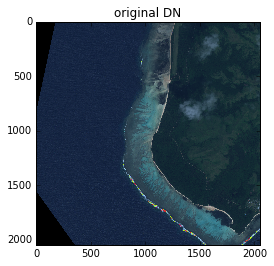

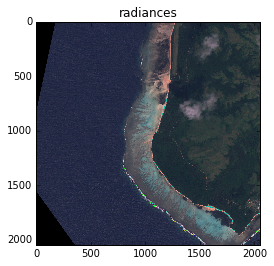

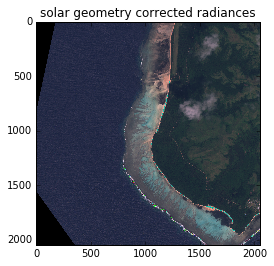

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R2C1-052985603010_01_P002_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R2C1-052985603010_01_P002_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R2C2-052985603010_01_P002.TIF  to correct
tif shape:  (2048, 2048, 8)


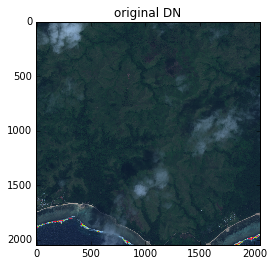

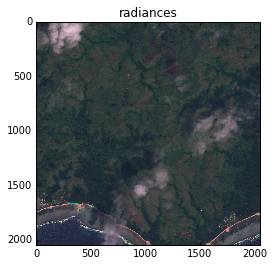

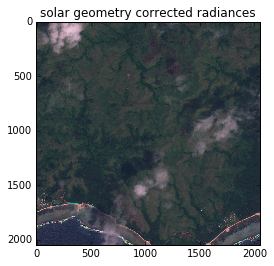

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R2C2-052985603010_01_P002_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R2C2-052985603010_01_P002_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R2C3-052985603010_01_P002.TIF  to correct
tif shape:  (2048, 1537, 8)


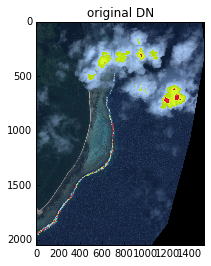

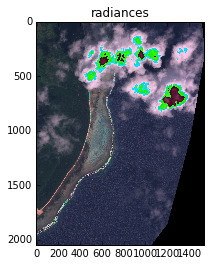

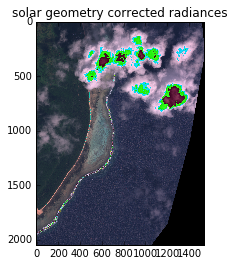

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R2C3-052985603010_01_P002_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R2C3-052985603010_01_P002_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R3C1-052985603010_01_P002.TIF  to correct
tif shape:  (838, 2048, 8)


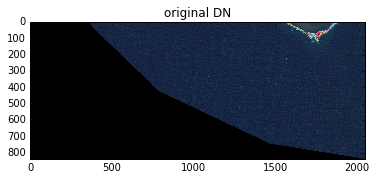

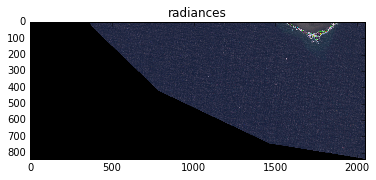

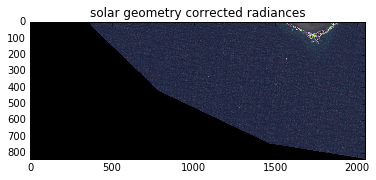

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R3C1-052985603010_01_P002_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R3C1-052985603010_01_P002_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R3C2-052985603010_01_P002.TIF  to correct
tif shape:  (916, 2048, 8)


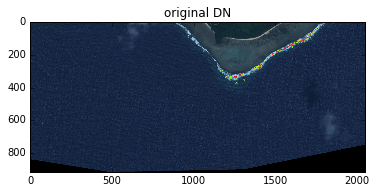

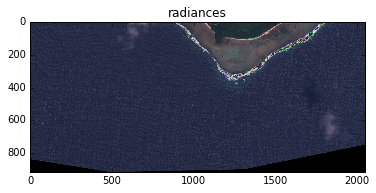

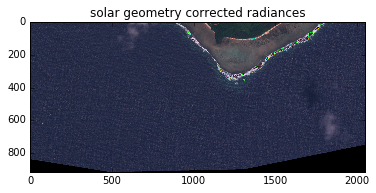

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R3C2-052985603010_01_P002_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R3C2-052985603010_01_P002_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R3C3-052985603010_01_P002.TIF  to correct
tif shape:  (749, 1050, 8)


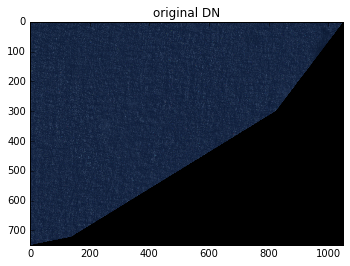

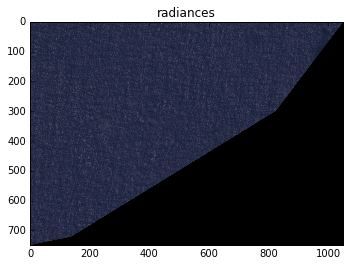

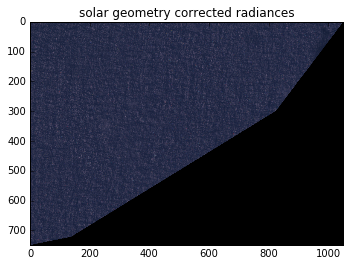

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R3C3-052985603010_01_P002_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P002_MUL\12DEC12223746-M2AS_R3C3-052985603010_01_P002_rad_solar_corrected.TIF
imd_f: D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS-052985603010_01_P003.IMD
2012-11-07T22:28:21.125678Z
['D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\\052985603010_01_P003_MUL\\12NOV07222821-M2AS_R1C1-052985603010_01_P003.TIF', 'D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\\052985603010_01_P003_MUL\\12NOV07222821-M2AS_R1C2-052985603010_01_P003.TIF', 'D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\\052985603010_01_P003_MUL\\12NOV07222821-M2AS_R1C3-052985603010_01_P003.TIF', 'D://NeMO-Net Data//Fiji Raw Imagery//Cicia/0529856030

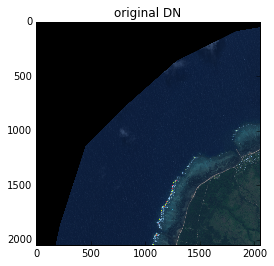

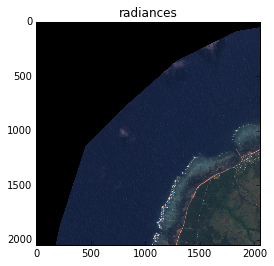

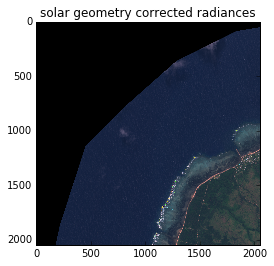

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R1C1-052985603010_01_P003_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R1C1-052985603010_01_P003_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R1C2-052985603010_01_P003.TIF  to correct
tif shape:  (2048, 2048, 8)


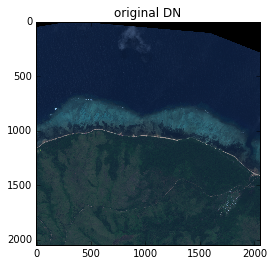

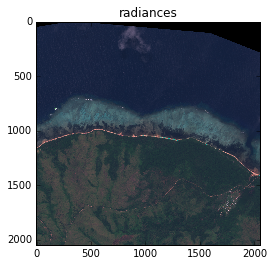

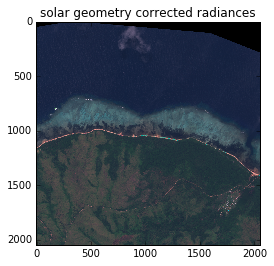

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R1C2-052985603010_01_P003_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R1C2-052985603010_01_P003_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R1C3-052985603010_01_P003.TIF  to correct
tif shape:  (2048, 1508, 8)


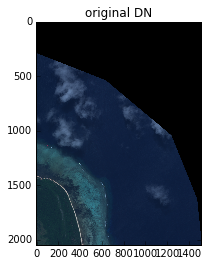

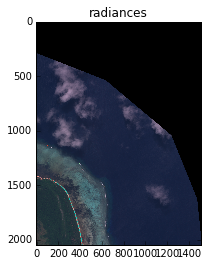

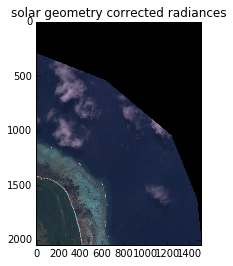

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R1C3-052985603010_01_P003_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R1C3-052985603010_01_P003_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R2C1-052985603010_01_P003.TIF  to correct
tif shape:  (2048, 2048, 8)


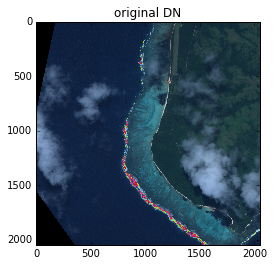

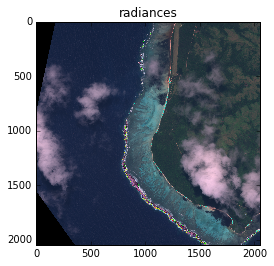

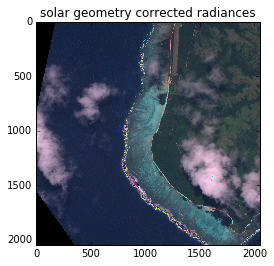

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R2C1-052985603010_01_P003_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R2C1-052985603010_01_P003_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R2C2-052985603010_01_P003.TIF  to correct
tif shape:  (2048, 2048, 8)


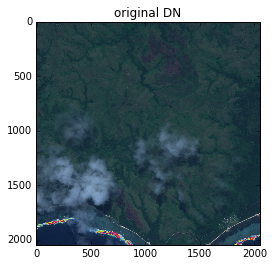

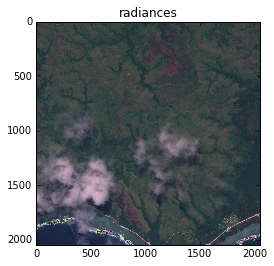

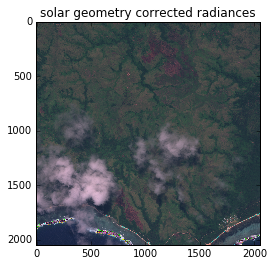

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R2C2-052985603010_01_P003_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R2C2-052985603010_01_P003_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R2C3-052985603010_01_P003.TIF  to correct
tif shape:  (2048, 1537, 8)


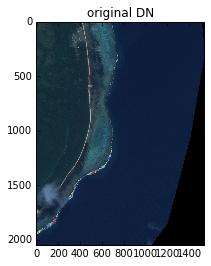

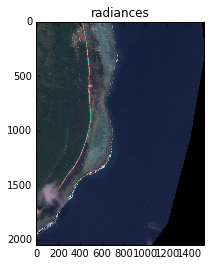

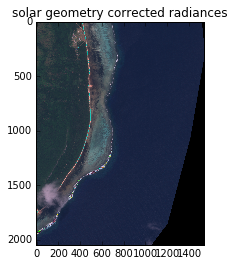

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R2C3-052985603010_01_P003_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R2C3-052985603010_01_P003_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R3C1-052985603010_01_P003.TIF  to correct
tif shape:  (838, 2048, 8)


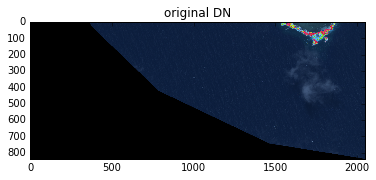

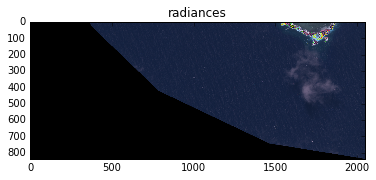

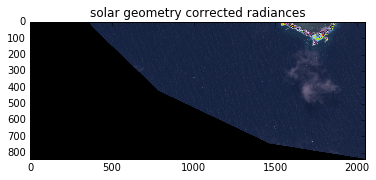

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R3C1-052985603010_01_P003_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R3C1-052985603010_01_P003_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R3C2-052985603010_01_P003.TIF  to correct
tif shape:  (916, 2048, 8)


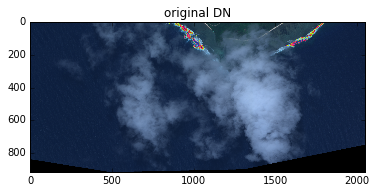

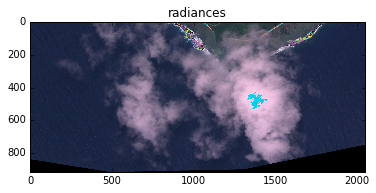

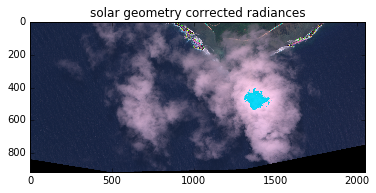

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R3C2-052985603010_01_P003_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R3C2-052985603010_01_P003_rad_solar_corrected.TIF
uploading:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R3C3-052985603010_01_P003.TIF  to correct
tif shape:  (749, 1050, 8)


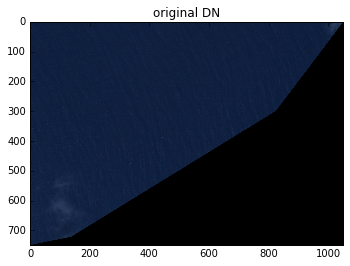

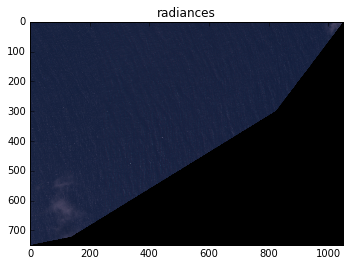

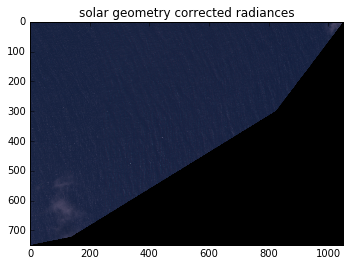

saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R3C3-052985603010_01_P003_rad_corrected.TIF
saving radiance correction into:  D://NeMO-Net Data//Fiji Raw Imagery//Cicia/052985603010_01\052985603010_01_P003_MUL\12NOV07222821-M2AS_R3C3-052985603010_01_P003_rad_solar_corrected.TIF


In [9]:
# read raw geotiff files and process them to be calibrated toa radiance sza corrected
#-------------------------------------------------------------------------------------

main_dir ='C://NeMO-Net Data//Fiji Raw Imagery//'
islands  = ['Cicia','Fulaga', 'Kobara', 'Mago','Matuka','Moala','Nayau', 'Totoya','Tuvuca', 'Vanua Balavu','Vanua Vatu']
islands  = ['Cicia']

for i in islands:
    print(i)
    island_dir = main_dir + i + "/"
    # search for subsir in each island
    subdir_ = [os.path.join(island_dir, o) for o in os.listdir(island_dir) 
                    if os.path.isdir(os.path.join(island_dir,o))]
    print(subdir_)
    
    for f in subdir_:
        dir_str = f + "/" + "*MUL"
        subdir = glob.glob(dir_str) 
        print(subdir)
        
        # perform operations on files in each directory in subdir:
        for ff in subdir:
            # open corresponding .IMD file and read parameters:
            imd_str = ff + "/" + "*.IMD"
            imd_f   = glob.glob(imd_str)
            print("imd_f:",str(imd_f[0]))
            cal_list = []
            bw_list  = []
            with open(imd_f[0]) as metadata_file:
                for line in metadata_file:
                    line = line.strip()
                    
                    if line.startswith('absCalFactor'):
                        tmp = line.find('=')
                        cal_factor = float(line[tmp+1:-1])
                        cal_list.append(cal_factor)
                    if line.startswith('effectiveBandwidth'):
                        tmp = line.find('=')
                        bandwidth = float(line[tmp+1:-1])
                        bw_list.append(bandwidth)
                    if line.startswith('meanSunAz'):
                        tmp = line.find('=')
                        meanSunAz = float(line[tmp+1:-1])
                    if line.startswith('meanSunEl'):
                        tmp = line.find('=')
                        meanSZA = 90. - float(line[tmp+1:-1])
                        mu = math.cos(math.radians(meanSZA))
                    if line.startswith('cloudCover'):
                        tmp = line.find('=')
                        cloudCover = float(line[tmp+1:-1])
                    if line.startswith('earliestAcqTime'):
                        tmp = line.find('=')
                        AcqTimeAll = (line[tmp+1:-1])
                        d_ES_sq = calc_d_ES( AcqTimeAll )
                #print(cal_list)
                #print(bw_list)
                #print(meanSunAz)
                #print(meanSZA)
                #print(mu)
                #print(cloudCover)
                #print(AcqTimeAll)
                #print(np.sqrt(d_ES_sq))
                
                ## load geotiff files to correct:
                tiff_str = ff + "/" + "*.tif"
                tif_f   = glob.glob(tiff_str)
                print(tif_f)
                for tf in tif_f:
                    match = re.search(r'P\d\d\d.TIF', tf)
                    if match:
                        print("uploading: ", tf, " to correct")
                        img = gdal.Open(tf)
                        xsize = img.RasterXSize
                        ysize = img.RasterYSize
                        projection = img.GetProjection()
                        image_DN = np.zeros((ysize,xsize,img.RasterCount))
                        image_rad= np.zeros((ysize,xsize,img.RasterCount))

                        for band in range(img.RasterCount):
                            band += 1
                            imgband = img.GetRasterBand(band)
                            image_DN[:,:,band-1]  = imgband.ReadAsArray()
                            image_rad[:,:,band-1] = ((imgband.ReadAsArray())*cal_list[band-1])/bw_list[band-1]


                        print("tif shape: ", image_DN.shape)
                        # create solar geometry corrected radiance array
                        image_geo = (image_rad*d_ES_sq)/mu

                        # plot original RGB before correction
                        img_RGB_DN = np.rollaxis(np.asarray([1/1016*image_DN[:,:,4],\
                                                                1/1543*image_DN[:,:,2], \
                                                                1/945*image_DN[:,:,1]]),0,3)

                        plt.figure(1)
                        plt.imshow(img_RGB_DN)
                        plt.title('original DN')
                        plt.show()

                        # plot radiance RGB after correction
                        img_RGB_rad = np.rollaxis(np.asarray([1/200*image_rad[:,:,4],\
                                                                1/300*image_rad[:,:,2], \
                                                                1/300*image_rad[:,:,1]]),0,3)

                        plt.figure(1)
                        plt.imshow(img_RGB_rad)
                        plt.title('radiances')
                        plt.show()

                        # plot radiance RGB after solar geometry correction
                        img_RGB_geo = np.rollaxis(np.asarray([1/200*image_geo[:,:,4],\
                                                                1/300*image_geo[:,:,2], \
                                                                1/300*image_geo[:,:,1]]),0,3)

                        plt.figure(1)
                        plt.imshow(img_RGB_geo)
                        plt.title('solar geometry corrected radiances')
                        plt.show()

                        ## save modified array into new geotiff
                        # radiances
                        newRasterfn_rad = tf[0:-4] + "_rad_corrected.TIF"
                        print("saving radiance correction into: ", newRasterfn_rad)
                        array2raster(newRasterfn_rad, img, image_rad)
                        # solar corrected radiances
                        newRasterfn_geo = tf[0:-4] + "_rad_solar_corrected.TIF"
                        print("saving radiance correction into: ", newRasterfn_geo)
                        array2raster(newRasterfn_geo, img, image_geo)


In [6]:
# test:
import re
tif_file_to_correct = "12NOV07222821-M2AS_R1C2-052985603010_01_P003.TIF"
tif_file_corrected  = "12NOV07222821-M2AS_R1C2-052985603010_01_P003_rad_corrected.TIF"
match = re.search(r'P\d\d\d.TIF', tif_file_corrected)
if match:
    print("processing tif file to correct")
else:
    print("already corrected")

already corrected
